ElasticNet
===

**Autores:** Matheus Pereira Velloso da Silveira e Mateus de Jesus Mendes

# Introdução

### Fundamentação Teórica

Em Machine Learning, a regressão linear é um dos modelos mais simples de previsão de dados. Porém, ela pode sofrer com o Underfit e Overfit. O que acontece é que a regressão linear faz previsões calculando um polinômio para tentar representar o resultado, porém, para representar com grande acurácia os dados de treino, é necessário um polinômio de grau alto, que pode gerar resultados melhores para os dados de treino, mas piores para os demais, ou seja overfit (super ajustado). Veja na imagem abaixo:
<div align="center">
    <img src="https://analystprep.com/study-notes/wp-content/uploads/2021/03/Img_13.jpg" alt="Fern vs Ehre" width="800">
</div>

https://analystprep.com/study-notes/wp-content/uploads/2021/03/Img_13.jpg

Pensando nisso, foram desenvolvidos modelos de regularização do grau desses polinômios para evitar o Overfit, como é o caso do L1 (LASSO) e L2 (Ridge). Ambos os métodos tentam diminuir o efeito de Overfitting da regressão. Primeiramento relembremos o cálculo do MSE:

$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$

Suponha que o valor a ser predito seja um polinômio tal que:
$$\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...$$

Substituindo:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - (\theta_0 + \theta_1 x_1 + \theta_2 x_2^2 + \theta_3 x_3^3 + \theta_4 x_4^4...))^2
$$

Chamemos o polinômio de f, para simplificar
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2
$$

Para diminuir o grau do polinômio, a regularização acrescenta um demérito para graus maiores. Veja como é feito em L2:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}(\theta_i)^2
$$
Ou seja, quanto maior n, maior o somatório dos quadrados de theta, sendo vantajoso um modelo que tenha menor grau e boa precisão. Alpha é uma constante que pode ser escolhida para ditar o peso do demérito.

Agora, vejamos como é feito em L1:
$$
MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha\sum_{i=1}^{n}|\theta_i|
$$
Ele também adiciona um demérito para o aumento de grau, mas agora usando o módulo de theta com a constante alpha.

Porém, podemos usar L1 e L2 juntos e isso é o Elastic Net:
$$
MSE = \frac{1}{2n}\sum_{i=1}^{n}(y_i - f(x_i))^2 + \alpha(l_1ratio)\sum_{i=1}^{n}|\theta_i| + 0.5\alpha(1-l_1ratio)\sum_{i=1}^{n}(\theta_i)^2
$$

#### ElasticNet no sklearn

No sklearn, ElasticNet está em linear_model. Ele pode receber como parâmetros:

→ alpha - controla o peso da regularização. std=1

→ l1_ratio - controla a proporção entre L1 e L2. std=0.5

→ max_iter - número máximo de iterações do algoritmo de otimização para encontrar a melhor solução. std=1000

→ tol - tolerância da melhoria para até onde o modelo tenta otimizar. std=1e-4

→ selection - cyclic, atualiza as features sequencialmente, random, atualiza em qualquer ordem. std=cyclic

→ fit_intercept - adiciona uma constante ao polinômio. std=true

→ positive - faz todos os thetas serem positivos. std=False

# Metodologia

### Importações

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

from optuna import create_study
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna import load_study, trial

import shap

### Definições Globais

Definições de parâmetros globais usados ao longo desse *Jupyter Notebook*, a fim de assegurar clareza metodológica e reprodutibilidade:

In [21]:
RANDOM_SEED = 88
PATH = '../dataset_processing/xtb_dataset.csv'
TRAIN_SIZE = 0.8
STUDY_NAME = 'elasticnet'

### Leitura dos Dados

Leitura do *dataset*:

In [18]:
df = pd.read_csv('../../dataset_processing/xtb_dataset.csv')

X = df.drop(columns=['Delta'])
y = df['Delta']

### Pré-processamento dos Dados

Divisão do *dataset* em subconjuntos de dados de treino e teste, considerando as *features* e o *target*:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

### Treino & Otimização de Hiperparâmetros

Definição de classe para aplicação do método de redução de dimensionalidade VIF (*Variance Inflation Factor*):

In [26]:
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0):
        self.thresh = thresh

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.features_ = list(range(X_df.shape[1]))

        while True:
            vif = pd.Series(
                [variance_inflation_factor(X_df.values, i)
                 for i in range(X_df.shape[1])],
                index=X_df.columns
            )

            max_vif = vif.max()
            if max_vif > self.thresh:
                drop_col = vif.idxmax()
                X_df = X_df.drop(columns=[drop_col])
                self.features_.remove(drop_col)
            else:
                break

        return self

    def transform(self, X):
        return X[:, self.features_]

Instância do modelo com todos os hiperparâmetros e tratamentos a serem usados pelo `optuna`.

In [27]:
def inst_elasticnet(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e3, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'positive': trial.suggest_categorical('positive', [False, True]),
        'max_iter': trial.suggest_int('max_iter', 1_000, 50_000),
        'tol': trial.suggest_float('tol', 1e-8, 1e-3, log=True),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

    pre_processing = trial.suggest_categorical('pre_processing', [None, 'stds', 'PCA', 'VT', 'RFE', 'VIF'])

    if pre_processing == 'stds':
        model = make_pipeline(
            StandardScaler(),
            ElasticNet(**params)
        )

    elif pre_processing == 'PCA':
        components = trial.suggest_int('pca_components', 2, 50)
        model = make_pipeline(
            StandardScaler(),
            PCA(n_components=components),
            ElasticNet(**params)
        )

    elif pre_processing == 'VT':
        threshold = trial.suggest_float('variance_threshold', 0, 0.1)
        model = make_pipeline(
            StandardScaler(),
            VarianceThreshold(threshold),
            ElasticNet(**params)
        )

    elif pre_processing == 'RFE':
        estimator = RandomForestRegressor(n_estimators=100, random_state=42)
        n_features = trial.suggest_int('rfe_features', 2, 50)
        model = make_pipeline(
            StandardScaler(),
            RFE(estimator=estimator, n_features_to_select=n_features),
            ElasticNet(**params)
        )

    elif pre_processing == 'VIF':
        vif_thresh = trial.suggest_float('vif_threshold', 5.0, 20.0)
        model = make_pipeline(
            StandardScaler(),
            VIFSelector(thresh=vif_thresh),
            ElasticNet(**params)
        )

    else:
        model = ElasticNet(**params)

    return model

Função objetivo para validação cruzada:

In [28]:
def objective_function(trial, X, y, num_folds, instantiator):
    model = instantiator(trial)

    metricas = -cross_val_score(
        model,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=num_folds,
        n_jobs=-1
    )
    return metricas.mean()

Função para executar os estudos de otimização do `optuna`:

In [29]:
def run_optuna(study_name, X, y, instantiator, num_folds=5, n_trials=1_000):

    sampler = TPESampler(
        n_startup_trials=50,
        multivariate=True,
        seed=42
    )

    pruner = MedianPruner(
        n_startup_trials=50
    )

    study = create_study(
        direction='minimize',
        study_name=study_name,
        storage=f'sqlite:///{study_name}.db',
        load_if_exists=True,
        sampler=sampler,
        pruner=pruner
    )

    def objective(trial):
        return objective_function(trial, X, y, num_folds, instantiator)

    study.optimize(objective, n_trials=n_trials)
    return study

Execução dos estudos de otimização de hiperparâmetros do `optuna`:

> **📌 Observação:** O seguinte código está comentado como célula Markdown por apresentar elevado custo computacional. Desse modo, é recomendada execução do *script* `ElasticNet.py` utilizando computação de alto desempenho (HPC) a fim de garantir eficiência e estabilidade computacional na execução dos estudos de otimização. Após isso, basta transferir o arquivo `elasticnet.db` para o mesmo diretório desse *Jupyter Notebook* e executar as células seguintes.

---
```python
study_en = run_optuna(STUDY_NAME, X_train, y_train, inst_elasticnet)
```
---

Acesso ao estudo de otimização, para extração dos melhores valores dos hiperparâmetros e o desempenho obtido:

In [22]:
study = load_study(
    study_name=STUDY_NAME,
    storage=f'sqlite:///{STUDY_NAME}.db'
)

Melhores hiperparâmetros obtidos durante a otimização:

In [23]:
study.best_params

{'alpha': 4.742486275093751e-05,
 'l1_ratio': 0.018589191548930475,
 'fit_intercept': True,
 'positive': False,
 'max_iter': 41963,
 'tol': 6.982053770448695e-07,
 'selection': 'random',
 'pre_processing': 'VT',
 'variance_threshold': 0.04137779740016238}

Desempenho ($\mathrm{RMSE}$) do melhor modelo obtido:

In [24]:
print(f'RMSE do melhor modelo: {study.best_value}')

RMSE do melhor modelo: 0.00015327052401779332


### Teste

Treino e teste finais para validação do melhor modelo obtido:

In [12]:
best_model = make_pipeline(
    StandardScaler(),
    VarianceThreshold(0.04137779740016238),
    ElasticNet(
        alpha=4.742486275093751e-05,
        l1_ratio=0.018589191548930475,
        fit_intercept=True,
        positive=False,
        max_iter=41963,
        tol=6.982053770448695e-07,
        selection='random'
    )
)
best_model.fit(X_train, y_train)

y_pred_best_model = best_model.predict(X_test)

rmse_best_model = root_mean_squared_error(y_test, y_pred_best_model)
print(f'RMSE do melhor modelo: {rmse_best_model}')

RMSE do melhor modelo: 0.000124312462013436


C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e+00, tolerance: 3.306e-01
  model = cd_fast.enet_coordinate_descent(


# Resultados

O melhor modelo induzido a partir do algoritmo ElasticNet durante a otimização de hiperparâmetros do `optuna` obteve $\mathrm{RMSE}$ de $0.00015$, dotado dos seguintes hiperparâmetros tabulados e com o conjunto de dados submetido à seleção de *features* do tipo *Variance Threshold*, com limiar de $0.041378$.

| Hiperparâmetros | Valor                       |
|-----------------|-----------------------------|
| `alpha`         | $\sim 4.742 \times 10^{-5}$ |
| `l1_ratio`      | $\sim 0.019$                |
| `fit_intercept` | `True`                      |
| `positive`      | `False`                     |
| `max_iter`      | $41,963$                    |
| `tol`           | $\sim 6.982 \times 10^{-7}$ |
| `selection`     | `"random"`                  |


Por fim, ao desenvolver o teste final, o modelo induzido com os hiperparâmetros supracitados obteve $\mathrm{RMSE}$ de $0.00012$, objetivamente menor, mas com mesma ordem de grandeza.

# SHAP

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, é necessário carregá-lo a partir do arquivo de estudo utilizando a função `load_study()`.

> **📌 Observação importante:** O *SHAP* não aceita um *pipeline* completo como entrada, ele requer um modelo final ou uma função de predição. Por isso, cria-se um *trial* “falso” (`FixedTrial`) com os melhores hiperparâmetros para instanciar o pipeline vencedor.

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`ElasticNet`), mas também inclui todas as etapas de pré-processamento do pipeline, como normalização, redução de dimensionalidade ou seleção de *features*. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.

In [40]:
# Carrega estudo do Optuna
study = load_study(study_name=STUDY_NAME, storage=f"sqlite:///{STUDY_NAME}.db")

# Extrai os melhores parâmetros
best_params = study.best_trial.params
fake_trial = trial.FixedTrial(best_params)

# Instancia o modelo com melhores parâmetros
melhor_modelo = inst_elasticnet(fake_trial)

# Treina o modelo
melhor_modelo.fit(X_train, y_train)

# Identifica quais steps o pipeline possui
steps = [name for name, _ in melhor_modelo.named_steps.items()] if hasattr(melhor_modelo, "named_steps") else []

# Obtém representações transformadas de X_train e X_test
X_train_transf, X_test_transf = X_train, X_test

if "standardscaler" in steps:
    scaler = melhor_modelo.named_steps["standardscaler"]
    X_train_transf = scaler.transform(X_train_transf)
    X_test_transf = scaler.transform(X_test_transf)

if "variancethreshold" in steps:
    var_th = melhor_modelo.named_steps["variancethreshold"]
    X_train_transf = var_th.transform(X_train_transf)
    X_test_transf = var_th.transform(X_test_transf)

if "pca" in steps:
    pca = melhor_modelo.named_steps["pca"]
    X_train_transf = pca.transform(X_train_transf)
    X_test_transf = pca.transform(X_test_transf)

if "rfe" in steps:
    rfe = melhor_modelo.named_steps["rfe"]
    X_train_transf = rfe.transform(X_train_transf)
    X_test_transf = rfe.transform(X_test_transf)
    selected_features = X_train.columns[rfe.get_support()]
else:
    # Caso não tenha RFE nem PCA, usa-se as colunas originais
    selected_features = getattr(X_train, "columns", [f"feat_{i}" for i in range(X_train.shape[1])])

# Identifica o modelo final (ElasticNet)
if hasattr(melhor_modelo, "named_steps"):
    modelo_final = melhor_modelo.named_steps["elasticnet"]
else:
    modelo_final = melhor_modelo

# Calcula as explicações do SHAP
explainer = shap.LinearExplainer(modelo_final, X_train_transf)
shap_values = explainer.shap_values(X_test_transf)

C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.767e+00, tolerance: 3.306e-01
  model = cd_fast.enet_coordinate_descent(


### *Summary Plot*

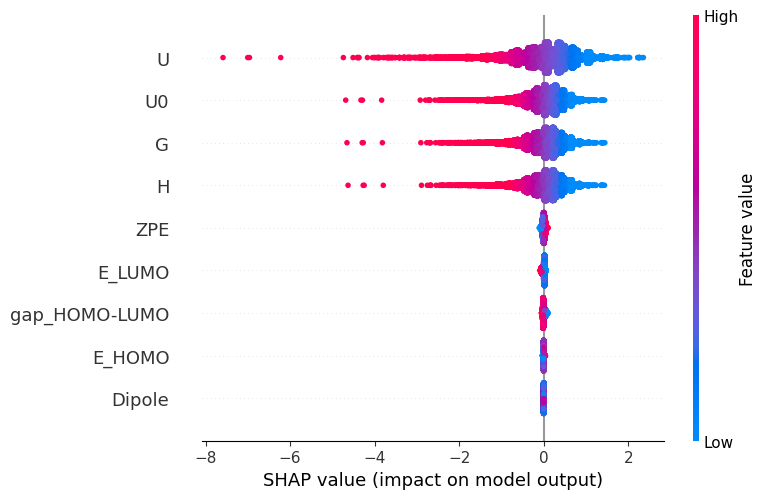

In [41]:
shap.summary_plot(shap_values, X_test_transf, feature_names=selected_features)

O gráfico acima é um *summary plot* do SHAP, mostrando a importância e direção do efeito de cada *feature* sobre as predições do modelo ElasticNet.

Observações principais:
1. **Features mais importantes:**  
   As variáveis `H`, `U`, `G` e `U0` apresentam os maiores valores absolutos de SHAP, indicando que são as que mais influenciam a saída do modelo.  

2. **Direção do efeito:**  
   - Pontos à esquerda (SHAP negativo) indicam que aumentar o valor da *feature* reduz a predição.  
   - Pontos à direita (SHAP positivo) indicam que aumentar a *feature* aumenta a predição.

3. **Cor das observações:**  
   - Tons mais vermelhos representam valores altos da *feature*.  
   - Tons mais azuis representam valores baixos da *feature*.  
   
   Assim, pode-se observar como a magnitude da *feature* está correlacionada com a direção do efeito no modelo. Por exemplo:
   
   - Para `H`, valores altos tendem a empurrar a predição para valores negativos, indicando efeito contrário ao alvo.  
   - Para `U`, valores altos também reduzem a predição, seguindo padrão similar.  

4. **Features menos relevantes:**  
   `ZPE`, `E_LUMO`, `E_HOMO`, `Dipole` e `gap_HOMO-LUMO` têm SHAP próximo de zero, mostrando que essas variáveis têm pouca influência sobre o modelo.  

Assim, pode-se concluir que modelo parece depender fortemente de um pequeno subconjunto de variáveis (`H`, `U`, `G`, `U0`), enquanto outras *features* contribuem pouco.

As indicações apresentadas pelo SHAP podem ser confirmadas por meio de uma nova previsão, mas somente com as *features* que o SHAP apresenta como as mais relevantes.

In [43]:
best_model = make_pipeline(
    StandardScaler(),
    VarianceThreshold(0.04137779740016238),
    ElasticNet(
        alpha=4.742486275093751e-05,
        l1_ratio=0.018589191548930475,
        fit_intercept=True,
        positive=False,
        max_iter=41963,
        tol=6.982053770448695e-07,
        selection='random'
    )
)

cv_best_model = -cross_val_score(
    best_model,
    X_test[['H', 'U', 'G', 'U0']],
    y_test,
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED),
    scoring='neg_root_mean_squared_error'
)

print(f'RMSE Médio (CV): {cv_best_model.mean()}')

C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+00, tolerance: 7.313e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e+00, tolerance: 7.387e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

RMSE Médio (CV): 0.005280748453500754


C:\Users\mateus25032\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e+00, tolerance: 7.312e-02
  model = cd_fast.enet_coordinate_descent(


Observa-se que ao manter as *features* de maior importância que o desempenho reduziu-se em uma ordem de grandeza, indo de um $\mathrm{RMSE}$ de $0.00015$ para $0.005$. Contudo, é importante observar que a métrica obtida considerando unicamente as quatro *features* principais apontadas pelo SHAP indica menor nível de *overfitting* e adequação metodológica, uma vez que necessita em menor uso de *features* pelo modelo e consequentemente menor custo computacional, descartando informações redundantes derivadas de multicolinearidade e que enviesam a depreensão de padrões do modelo induzido e reduzem a capacidade de generalização final.

### *Bar Plot*

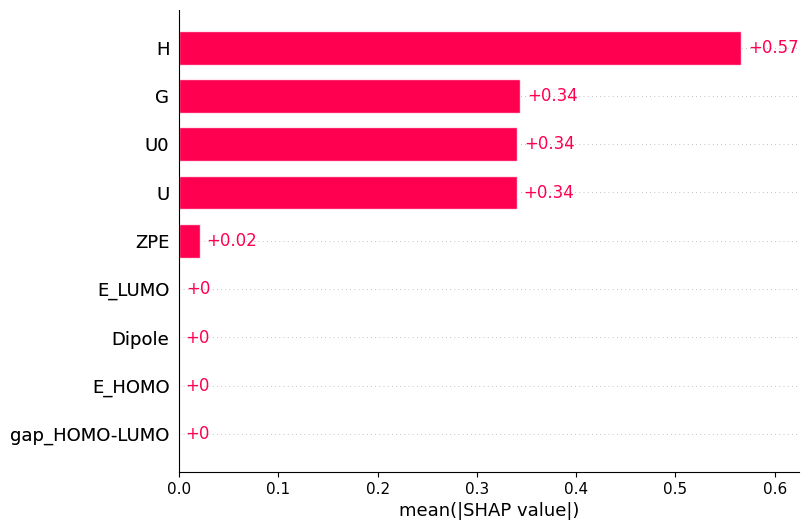

In [38]:
shap_values_exp = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

O gráfico de barras apresenta a importância global das variáveis de acordo com o valor médio absoluto dos *SHAP values*.  
Ele indica, em média, quanto cada variável contribui para alterar as previsões do modelo — independentemente de aumentar ou diminuir o valor predito.

- O eixo horizontal mostra o valor médio de $|\mathrm{SHAP}|$, ou seja, a intensidade média do impacto.  
- As variáveis são ordenadas de forma decrescente, destacando as que mais influenciam o modelo.  
- Valores próximos de zero indicam que a *feature* tem pouca ou nenhuma influência sobre as previsões.

**Interpretação:** O que foi mostrado no *summary plot* é apenas reforçado por uma via mais quantitativa.

### *Waterfall Plot*

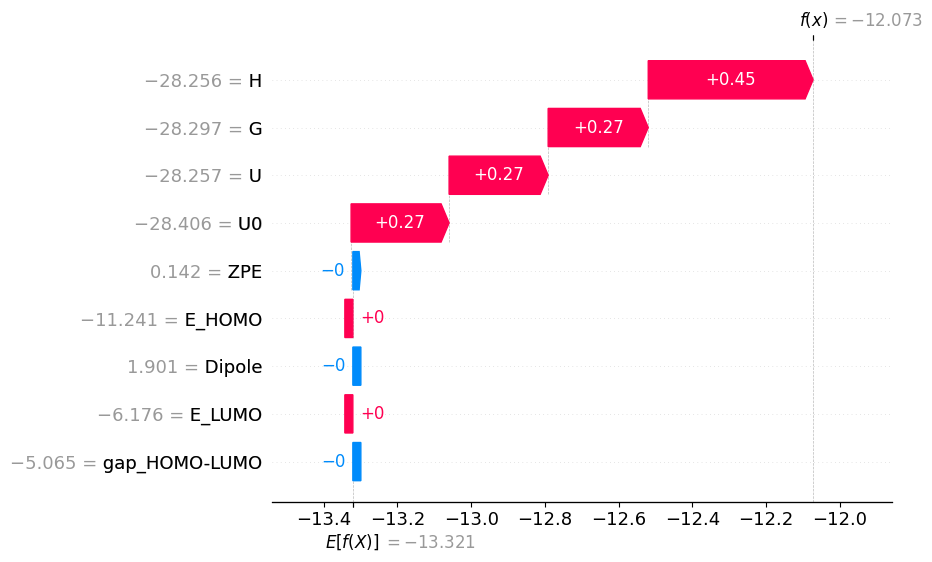

In [39]:
shap.plots.waterfall(shap_values_exp[0])

O gráfico *waterfall* detalha como cada variável contribuiu para uma predição específica do modelo.

Partindo da média global das predições $\left(\mathbb{E}[f(X)]\right)$, o gráfico mostra passo a passo o efeito de cada *feature* até chegar ao valor final $f(x)$ da amostra analisada.

- As **barras azuis** indicam *features* que **reduzem** a previsão (impacto negativo).  
- As **barras vermelhas** representam *features* que **aumentam** a previsão (impacto positivo).  
- À esquerda, vê-se o valor médio da variável na amostra e sua respectiva contribuição.

**Interpretação:** Para essa instância, as variáveis `G`, `U`, `H` e `U0` têm forte influência negativa, reduzindo o valor final previsto $\left( f(x) = -12.073 \right)$. Já as demais variáveis têm impacto quase nulo. Assim, o gráfico mostra como a combinação específica dos valores dessas variáveis levou o modelo a fazer essa predição em particular, revelando a explicabilidade local do modelo.

# Conclusão

A análise conduzida neste notebook, apoiada nas técnicas de interpretabilidade baseadas em SHAP, permite uma conclusão objetiva e diretamente fundamentada nos resultados empíricos. O *summary plot* mostra de forma consistente que o ElasticNet otimizado via Optuna não distribui uniformemente sua capacidade explicativa: a maior parte da contribuição para as predições está concentrada em um subconjunto reduzido de *features*, notadamente `H`, `U`, `G` e `U0`, cujos valores absolutos de SHAP superam amplamente os das demais variáveis. Isso indica que, embora o treinamento envolva um espaço de alta dimensionalidade, o modelo opera efetivamente em uma subestrutura de menor dimensão.

A direção dos efeitos revela uma relação sistemática e estável: valores elevados de `H`, `U`, `G` e `U0` contribuem predominantemente de forma negativa para a predição, deslocando-a para valores menores. Tal comportamento recorrente evidencia que o modelo internalizou uma estrutura linear global coerente com o regime de regularização imposto pelo ElasticNet, reforçando a interpretação de um núcleo explicativo compacto e dominante.

Em contraste, variáveis como `ZPE`, `E_LUMO`, `E_HOMO`, `Dipole` e `gap_HOMO-LUMO` apresentam valores de SHAP próximos de zero ao longo de todo o conjunto de dados, indicando influência marginal nas decisões do modelo. Essa evidência sugere a presença de informação redundante ou fracamente correlacionada com o alvo, possivelmente associada à multicolinearidade ou a sinais preditivos de baixa intensidade.

Essa leitura é confirmada quantitativamente pelo *bar plot* de valores médios absolutos de SHAP, que reproduz a mesma hierarquia observada no *summary plot*. As quatro *features* dominantes concentram praticamente todo o impacto médio nas predições, enquanto as demais contribuem de forma residual, fortalecendo a robustez da conclusão.

A análise local, via *waterfall plot*, mostra que essa estrutura se mantém em nível individual. Para a instância analisada, `H`, `U`, `G` e `U0` explicam quase integralmente o deslocamento da média global até a predição final $f(x) = -12.073$, enquanto o restante das variáveis exerce impacto desprezível. Há, portanto, consistência estrutural entre as interpretações global e local.

A partir dessas evidências, testou-se a hipótese de treinar o modelo apenas com as *features* mais relevantes. O resultado confirma o trade-off esperado: ao restringir o conjunto a `H`, `U`, `G` e `U0`, o RMSE aumenta de aproximadamente $1.5 \times 10^{-4}$ para $5 \times 10^{-3}$. Essa degradação não invalida o modelo reduzido, mas reflete a perda do efeito cumulativo de múltiplos sinais fracos e redundantes presentes no conjunto completo de variáveis.

Em contrapartida, o modelo reduzido oferece vantagens metodológicas claras, como menor complexidade, menor custo computacional, mitigação da multicolinearidade e menor propensão ao *overfitting*. Assim, o modelo completo otimizado pelo Optuna maximiza o desempenho numérico ao explorar redundâncias informacionais, enquanto a análise guiada por SHAP explicita a estrutura interna do modelo e permite escolhas conscientes entre desempenho máximo e parcimônia, conforme os objetivos analíticos do estudo.

# Referências

[1] AWAN, Abid Ali. Uma introdução aos valores SHAP e à interpretabilidade do aprendizado de máquina. DataCamp, 11 set. 2024. Disponível em: https://www.datacamp.com/pt/tutorial/introduction-to-shap-values-machine-learning-interpretability. Acesso em: 24 out. 2025.

[2] DATACAMP. Tutorial: Regressão Lasso e Ridge no Python. 2025. Disponível em: https://www.datacamp.com/pt/tutorial/tutorial-lasso-ridge-regression. Acesso em: 27 set. 2025.

[3] LIGEIRO, Gabriel. Como interpretar seu modelo de machine learning usando SHAP values. Medium, 5 dez. 2020. Disponível em: https://gabrielligeiro.medium.com/como-interpretar-seu-modelo-de-machine-learning-usando-shap-values-2c61c0d26317. Acesso em: 24 out. 2025.

[4] Mendes, Mateus de Jesus. Modelos 6. [Jupyter Notebook][Material de circulação restrita], Campinas: Ilum - Escola de Ciência, 2025.

[5] Neto, Aniel de Souza Ribeiro. Modelos 7. [Jupyter Notebook][Material de circulação restrita], Campinas: Ilum - Escola de Ciência, 2025.

[6] Silveira, Matheus Pereira Velloso da. Modelos 3. [Jupyter Notebook][Material de circulação restrita], Campinas: Ilum - Escola de Ciência, 2025.

[7] ZINI, Fernando. Regressão Linear: Teoria e Prática. YouTube, 10 set. 2023. Disponível em: https://www.youtube.com/watch?v=VqKq78PVO9g. Acesso em: 27 set. 2025.